# SEP on f105w band image of the Hubble Ultra Deep Field

Altered from: https://sep.readthedocs.io/en/v1.0.x/tutorial.html 

In [73]:
# import all the packages we need
import numpy as np
import sep

#for reading the image
from astropy.io import fits

#for displaying plots
import matplotlib.pyplot as plt
from matplotlib import rcParams
# %matplotlib inline

rcParams['figure.figsize'] = [10., 8.]

Then we open the fits test image and display it, so that we can see what info we're dealing with.

In [74]:
# open fits file and read image data 
with fits.open("hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits") as hdul:
    data = hdul[0].data

# it's a standard numpy array
# type(data)
    

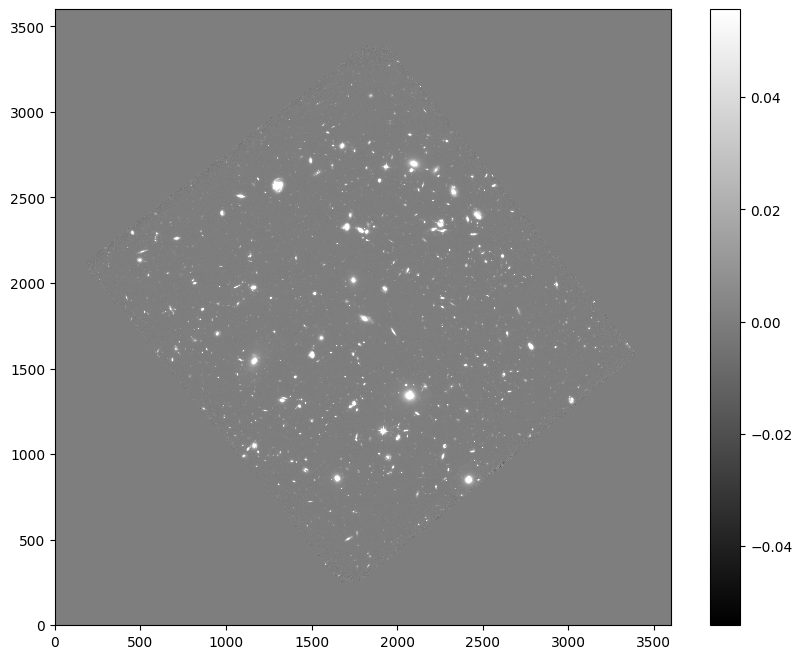

In [75]:
# show the image
m, s = np.mean(data), np.std(data) #get the mean and std

#imshow takes the image data, type of interpolation (estimation), a color map type,
#the data range that the color map covers (vmin to vmax)*,
#and where to place start the data from [0,0] of the image array
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')

#display a colorbar
plt.colorbar();

# *here they are calculated by +/- one std from the mean

plt.savefig('f105w-HUDF.png', bbox_inches='tight')

## Background Subtraction

Measure the background of the image.

In [76]:
# Fix byte order
data = data.byteswap().newbyteorder()

bkg = sep.Background(data) #Returns a 'Background' object

Evaluate the background as a 2-d array the same size as the original image

In [77]:
bkg_image = bkg.back()# bkg_image = np.array(bkg) is equivalent

Show the background as an image

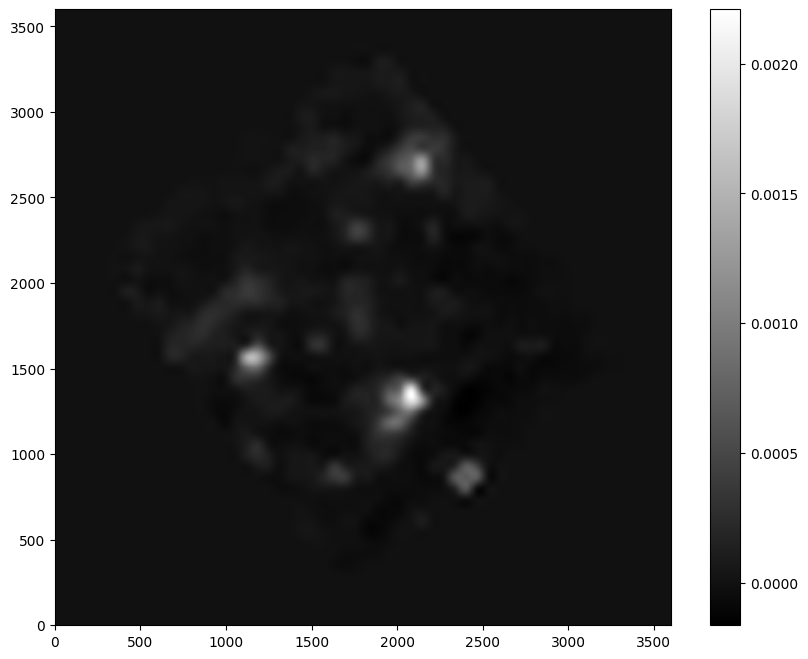

In [78]:
# show the background
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

# save the figure as png
plt.savefig('f105w-HUDF-background.png', bbox_inches='tight')

- Evaluate the background noise as a 2-d array the same size as the original image

In [79]:
bkg_rms = bkg.rms()

- Show the background noise as an image from the 2-d array we just created

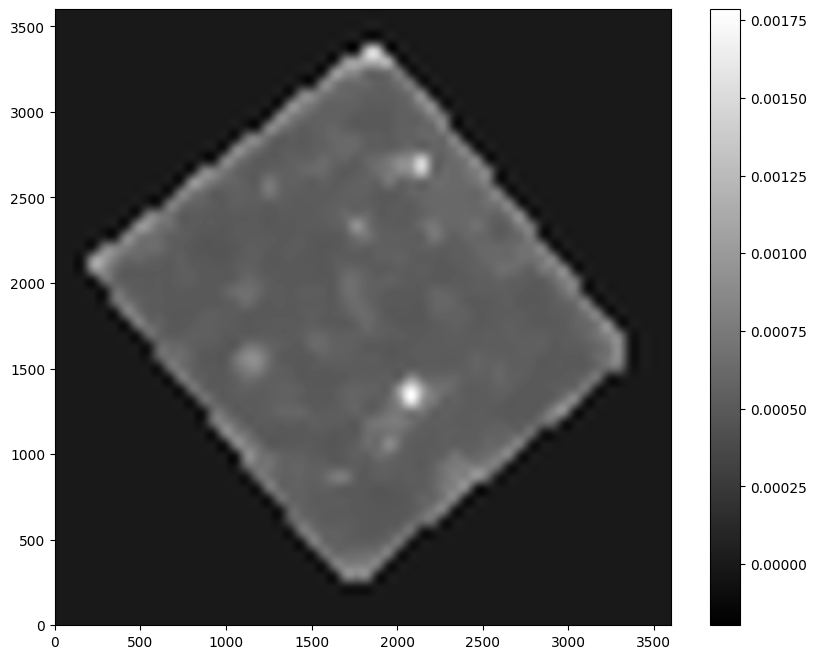

In [80]:
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

# save image
plt.savefig('f105w-HUDF-background-noise.png', bbox_inches='tight')

- Subtract the background we computed from the original data 

In [81]:
# subtract the background
data_sub = data - bkg # In-place version: bkd.subfrom(data)

## Object Detection

After the background has been subtracted, we can now run object detection on the background-subtracted data.

Note: For this image, I doubled the detection threshold because I interpreted the image as 'less flat' as the example image. I interpreted 'flatness' as the transition distance from white to black. The background noise level image here has several dots of white, as opposed to the clear gradient shown in the example.

In [82]:
objects = sep.extract(data_sub, 3, err=bkg.globalrms, minarea=5) #Returns a structed np array

#view how many objects were detected
print(len(objects))

4354


The following cell over-plots the object coordinates using matplotlib.patches Ellispe onto the original image.

In [83]:
# get ellipses
from matplotlib.patches import Ellipse

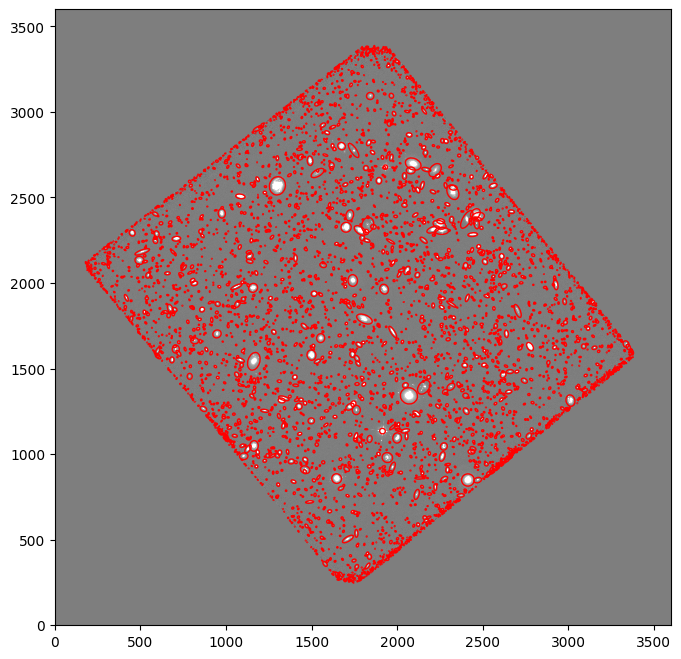

In [84]:
# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e) #add the ellipse to the axes

plt.savefig('f105w-HUDF-identified-objects.png', bbox_inches='tight')

## Aperture Photometry

The final step is to perform 'simple circular aperture photometry with a 3 pixel radius at the locations of the objects'.

*flux, fluxerr, and flag are all 1-d arrays with one entry per object found

In [85]:
# sep.sumcircle takes the subtracted data, the x, y locations of the located objects, 
# a pixel radius of the aperature, an error, and a gain*
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'],
                                     3.0, err=bkg.globalrms, gain=1.0)

# * gain : float, optional
#       Conversion factor between data array units and poisson counts,
#       used in calculating poisson noise in aperture sum

## Histogram the fluxes

In [86]:
print(f"{len(flux)} sources were found.")

4354 sources were found.


### Using Chauvenet's Criterion

For the histogram, I used Chauvenet's Criterion to find possible outliers. I tried histogramming the data without identifying outliers, however the resulting histogram was nonsensical to read. 

In [87]:
#import erf
from scipy.special import erf

In [88]:
#computes the probability of an event
#of magnitude x or greater from
#a gaussian distribution
def event_probability(x, mu=0.0, s=1.0):
    #x is the value of the event
    #mu is the gaussian mean (default 0.0)
    #s is the std dev (default 1.0)

    #s is how many sigma away x is from the mean
    z = np.fabs((x-mu)/s)

    return 1.0 - erf(z/np.sqrt(2))

In [89]:
def chauvenet_criterion(prior_measurements, outlier):
    #prior_measurements is our set of previous measurements
    #outlier is the value we want to check

    #returns True if the outlier can be discarded
    #returns False if the outlier cannot be immediately discarded

    #compute mean and std of prior measurements
    #and assume these are representative of the gaussian
    mean = np.mean(prior_measurements)
    std = np.std(prior_measurements)

    #compute the probability of the outlier
    outlier_probability = event_probability(outlier, mu=mean, s=std)

    #get the number of events, include new outlier
    N = len(prior_measurements) + 1

    #check Chauvenet's criterion
    if (N * outlier_probability < 0.5) :
        return True
    
    #if we are here in the code, then the above condition was false
    #we cannot discard the outlier
    return False

In [90]:
# Get all fluxes 5 sigma or more away from mean
sigma5_flux = [i for i in flux if chauvenet_criterion(flux, i) == True]

print(sigma5_flux)

[72.34869235038758, 65.88959391593934, 807.1093853378296, 52.02831772565844, 77.9742225933075, 55.7442670273781, 214.23730161190034, 81.51146807432175]


In [91]:
#Get all fluxes 4 sigma or less away from the mean
checked_flux = [i for i in flux if chauvenet_criterion(flux, i) == False]
print(len(checked_flux))
print(max(checked_flux))

4346
45.708980941772474


In [92]:
#create the histogram bins
width = .5
histmin =  -1.5
histmax = 46

print(min(checked_flux), max(checked_flux))

bins = np.arange(histmin, histmax, width)

-1.206750793821887 45.708980941772474


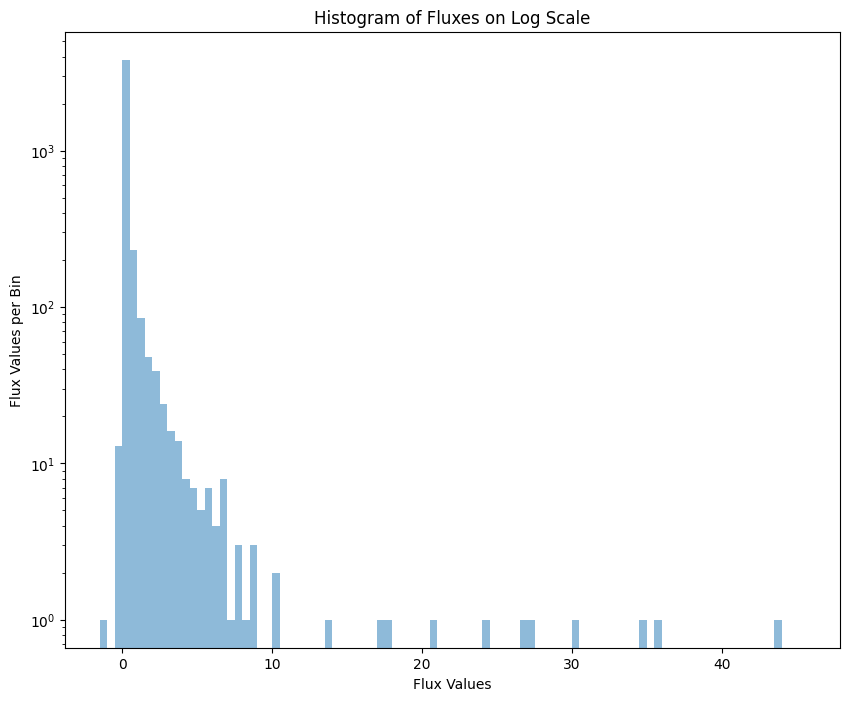

In [93]:
#create historgram
fig = plt.figure()

ax = fig.add_subplot(1,1,1)
ax.hist(checked_flux, bins = bins, alpha = 0.5, density=False)
ax.set_yscale('log')

plt.xlabel('Flux Values')
plt.ylabel('Flux Values per Bin')
plt.title('Histogram of Fluxes on Log Scale')
plt.show()

## Statistical Info

What are the mean, median, and standard deviation of the distribution of fluxes?

In [94]:
flux_mean = np.mean(flux)
flux_median = np.median(flux)
flux_std = np.std(flux)

print(f'The mean of the distribution of the fluxes is {flux_mean}.')
print(f'The median of the distribution of the fluxes is {flux_median}.')
print(f'The standard deviation of the distribution of the fluxes is {flux_std}.')

The mean of the distribution of the fluxes is 0.7032657852029849.
The median of the distribution of the fluxes is 0.07347932905657217.
The standard deviation of the distribution of the fluxes is 13.010893188503553.


What is the largest outlier in the distribution?

In [95]:
flux_max = np.max(flux)

print(f'The largest outlier of the distribution of the fluxes is {flux_max}.')

The largest outlier of the distribution of the fluxes is 807.1093853378296.


Where is the largest outlier on the image?

In [96]:
#find index of outlier flux in fluxes
index_max_flux = None
for i, value in enumerate(flux):
    if value == flux_max:
        print(i)
        index_max_flux = i
        break

#theoretically, this index will be the same index as the object is at
#in the object position lists and can be used to locate it


983


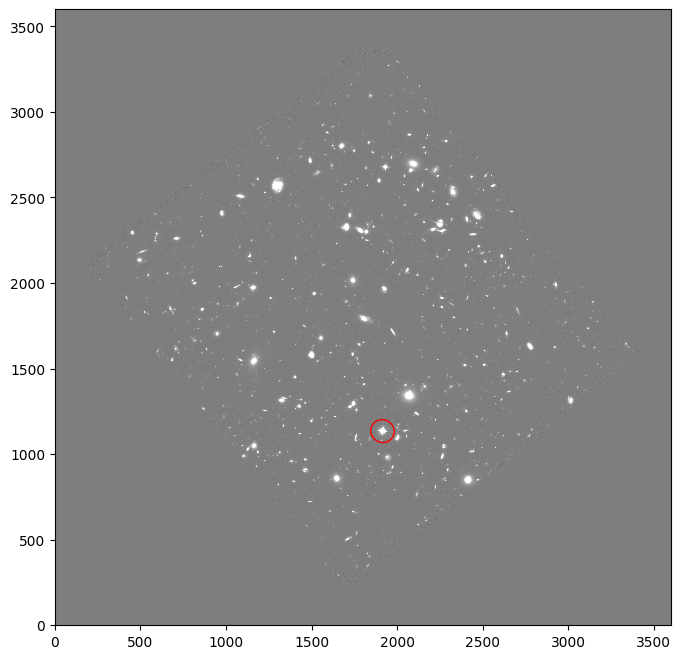

In [97]:
# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse only for the largest outlier on the image
# ellipse made bigger than initial graphing to capture its
# accompanying diffraction spikes
e = Ellipse(xy=(objects['x'][index_max_flux], objects['y'][index_max_flux]),
            width=25*objects['a'][index_max_flux],
            height=25*objects['b'][index_max_flux],
            angle=objects['theta'][index_max_flux] * 180. / np.pi)
e.set_facecolor('none')
e.set_edgecolor('red')
ax.add_artist(e) #add the ellipse to the axes

plt.savefig('f105w-HUDF-max-flux-object.png', bbox_inches='tight')

How many standard deviations is the largest outlier away from the mean?

In [98]:
#(outlier - mean) / std should tell me how many stds it's away from the mean
stds_max_flux = (flux_max - flux_mean) / flux_std

print(f'''The largest outlier, {flux_max} is about {stds_max_flux:.2f} 
standard deviations away from the mean, {flux_mean}.''')


The largest outlier, 807.1093853378296 is about 61.98 
standard deviations away from the mean, 0.7032657852029849.


## 3-color false image of the UDF using RGB

Make a 3-color false image of the UDF using RGB -> f160w, f125w, f105w. Save the image as a PNG.

In [99]:
# open fits file and read image data 
with fits.open("hlsp_hudf12_hst_wfc3ir_udfmain_f125w_v1.0_drz.fits") as hdul:
    dataG = hdul[0].data

with fits.open("hlsp_hudf12_hst_wfc3ir_udfmain_f160w_v1.0_drz.fits") as hdul:
    dataR = hdul[0].data

dataB = data

In [100]:
#From Session 18
def rescale_image(data):
    #copy the data to avoid accidentally overwriting it
    pdata_tmp = data.copy()

    # compute the mean value over all data, excluding NaN (Not a Number)
    m = np.nanmean(pdata_tmp)

    # if lower than vpmin, apply vpmin
    # if higher than vpmax, apply vpmax
    vpmin = 0.5*m
    vpmax = 100*m
    pdata_tmp[pdata_tmp<vpmin] = vpmin
    pdata_tmp[pdata_tmp>vpmax] = vpmax

    #apply logscale
    pdata_tmp = np.log10(pdata_tmp)
    return pdata_tmp

In [101]:
#From Session 18
def remap(data):
    #copy the data to avoid accidentally overwriting it
    pdata_tmp = data.copy()

    dmin = pdata_tmp.min()
    dmax = pdata_tmp.max()

    return (pdata_tmp - dmin) / (dmax-dmin)

In [102]:
# From Altered from Session 18
# Let's combine the data and use RGB color-formatting
data_all = np.zeros((dataR.shape[0], dataR.shape[1], 3))

data_all[:,:,0] = dataR
data_all[:,:,1] = dataG 
data_all[:,:,2] = dataB 

data_res_all = rescale_image(data_all)

In [103]:
#Altered from Session 18
rgb_image = np.zeros((dataR.shape[0], dataR.shape[1], 3))

rgb_image = remap(data_res_all)

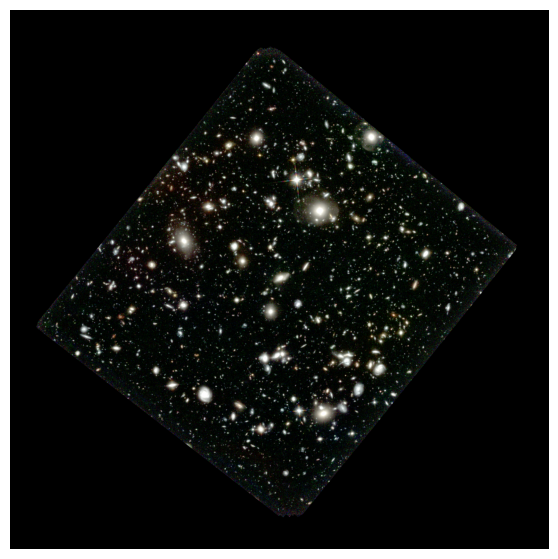

In [104]:
# Altered from Session 18
f, ax = plt.subplots(1, 1, figsize=(7,7))
ax.axis('off')
ax.imshow(rgb_image)

plt.savefig('3-color-false-image.png', bbox_inches='tight', pad_inches=0, dpi=600)